In [ ]:
# downloaded from https://grouplens.org/datasets/movielens/25m/

In [21]:
import numpy as np
arr = np.array([1,2 , 3])
arr

array([1, 2, 3])

In [32]:
numbers = [i for i in range(10)]

In [33]:
numbers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [42]:
numbers[2:7:2]

[2, 4, 6]

In [43]:
numbers[2:7:3]

[2, 5]

In [44]:
numbers[2:9:3]

[2, 5, 8]

In [41]:
numbers[::-1]

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [28]:
food = ['candy', 'icecream', 'mochi']
rudra = [0, 1, 2, 2, 2, 2]
[food[0], food[1], food[2], food[2], food[2], food[2]]

['candy', 'icecream', 'mochi', 'mochi', 'mochi', 'mochi']

In [31]:
[food[meal] for meal in rudra]

['candy', 'icecream', 'mochi', 'mochi', 'mochi', 'mochi']

In [30]:
for meal in food:
    print(meal)
    if meal == 'icecream':
        print('i love icecream')

candy
icecream
i love icecream
mochi


In [24]:
nums = [1, 2, 3]
return 6 in [nums[i] for i in [0, -1]]

TypeError: list indices must be integers or slices, not list

In [23]:
6 in arr[[0, -1]]

False

In [15]:
class A:
    blah = {}
    def a(self):
        self.blah[1] = 2
        

In [13]:
A.blah

{1: 2}

In [8]:
a = A()

In [10]:
a.a()

In [11]:
a.blah

{1: 2}

In [138]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import time
from tqdm import tqdm
dbg = True
# from google.colab import drive
# drive.mount('/content/gdrive')
nrows = {True:100000, False:None}[dbg]
rating_df = pd.read_csv('ml-25m/ratings.csv', nrows=nrows)
tag_df = pd.read_csv('ml-25m/tags.csv', nrows=nrows)
movie_df = pd.read_csv('ml-25m/movies.csv')
rating_df['userId'] = rating_df['userId'] - 1
rating_df['movieId'] = rating_df['movieId'] - 1
tag_df['userId'] = tag_df['userId'] - 1
tag_df['movieId'] = tag_df['movieId'] - 1
movie_df['movieId'] = movie_df['movieId'] - 1
rating_df['movieId'] = rating_df['movieId'].map({v: i for i, v in enumerate(rating_df['movieId'].unique())})
mismatch = set(rating_df["movieId"]).difference(movie_df["movieId"])
rating_df = rating_df.loc[~rating_df['movieId'].isin(mismatch)]

movie_counts = rating_df['movieId'].value_counts()
popular_movies = movie_counts[(movie_counts > 30)].index
rating_df = rating_df.loc[rating_df['movieId'].isin(popular_movies)]
user_counts = rating_df['userId'].value_counts()
popular_users = user_counts[(user_counts > 30)].index
rating_df = rating_df.loc[rating_df['userId'].isin(popular_users)]

movie_df = movie_df.loc[movie_df['movieId'].isin(rating_df['movieId'].unique())]
movie_id_map = {v:k for k, v in enumerate(rating_df['movieId'].unique())}
movie_df['movieId'] = movie_df['movieId'].map(movie_id_map).astype(int)
rating_df['movieId'] = rating_df['movieId'].map(movie_id_map).astype(int)
user_id_map = {v:k for k, v in enumerate(rating_df['userId'].unique())}
rating_df['userId'] = rating_df['userId'].map(user_id_map).astype(int)
rating_df = rating_df.reset_index(drop=True)
movie_df = movie_df.reset_index(drop=True)
mismatch = set(movie_df["movieId"]).difference(rating_df["movieId"])
movie_df = movie_df.drop(mismatch)
num_users = rating_df['userId'].nunique()
num_movies = rating_df['movieId'].nunique()

In [139]:
rating_df['movieId'].value_counts()

78      80494
75      79990
0       78776
254     73227
154     71871
        ...  
6690      101
6103      101
6323       99
6551       99
5226       99
Name: movieId, Length: 7023, dtype: int64

In [140]:
rating_df.shape[0]/(rating_df['movieId'].nunique() * rating_df['userId'].nunique())

0.02097314599846764

In [141]:
rating_df['userId'].value_counts()

69080     5906
19130     4573
54983     4388
32316     4377
77350     4366
          ... 
104213      21
10997       21
66563       21
61741       21
15554       21
Name: userId, Length: 155317, dtype: int64

In [142]:
movie_df.index.nunique()

7023

In [143]:
set(rating_df["movieId"]).difference(movie_df.index)

set()

In [144]:
set(movie_df.index).difference(rating_df["movieId"])

set()

In [145]:
rating_df.shape

(22877325, 4)

In [146]:
rating_df['weight'] = 1

In [150]:
train_rows=np.random.choice(rating_df.shape[0], int(0.8*rating_df.shape[0]), replace=False)
ratings_train = rating_df.loc[train_rows]
test_rows = set(range(rating_df.shape[0])).difference(set(train_rows))
ratings_test = rating_df.loc[test_rows]

In [151]:
tfph = tf.compat.v1.placeholder
tfvar = tf.compat.v1.get_variable
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
emb_size = 32
user_ph = tfph(shape = (None), dtype = tf.int32)
movie_ph = tfph(shape = (None), dtype = tf.int32)
ratings_ph = tfph(shape = (None), dtype = tf.float32)
user_var = tfvar('users', shape = (num_users, emb_size), dtype = tf.float32)
movies_var = tfvar('movies', shape = (num_movies, emb_size), dtype = tf.float32)
user_bias = tfvar('user_bias', shape = (num_users,), dtype = tf.float32)
movie_bias = tfvar('movie_bias', shape = (num_users,), dtype = tf.float32)

weight_ph = tfph(shape = (None), dtype = tf.float32)

In [152]:
minrating, maxrating = rating_df['rating'].describe().loc[['min', 'max']]

In [153]:
user_embed = tf.nn.embedding_lookup(user_var, user_ph)
movies_embed = tf.nn.embedding_lookup(movies_var, movie_ph)
user_bias_sample = tf.gather(user_bias, user_ph)
movie_bias_sample = tf.gather(movie_bias, movie_ph)

score = tf.reduce_sum(user_embed * movies_embed, axis = 1) + user_bias_sample + movie_bias_sample
score =tf.math.sigmoid(score)*(maxrating - minrating)+minrating

MSE = tf.reduce_mean(tf.square(ratings_ph - score) * weight_ph)
reg=tf.reduce_mean(tf.square(user_embed)) + tf.reduce_mean(tf.square(movies_embed))
reg_ph = tfph(shape = (), dtype = tf.float32)

sess = tf.compat.v1.Session()
opt = tf.compat.v1.train.AdamOptimizer(learning_rate = 1e-2).minimize(MSE+reg*reg_ph)
sess.run(tf.compat.v1.global_variables_initializer())

In [154]:
user_probs = rating_df['userId'].value_counts()
user_probs = user_probs / user_probs.sum()
movie_probs = rating_df['movieId'].value_counts()
movie_probs = movie_probs / movie_probs.sum()

In [155]:
losses=[]
val_losses=[]
train_losses=[]
correlation=[]
total_training_time = 0
total_validation_time = 0
batch_size = 64

for i in tqdm(range(7000)):
    start = time.time()
    samples = np.random.choice(ratings_train.shape[0], batch_size, replace = False)
    user_samples = np.random.choice(num_users, size=batch_size, replace=False, p = user_probs)
    movie_samples = np.random.choice(num_movies, size=batch_size, replace=False, p = movie_probs)
    neg_samples = pd.DataFrame({'userId': user_samples, 'movieId': movie_samples, 'rating': minrating, 'weight': .1})
    current_reg = i/10
    df_pos = ratings_train.iloc[samples]
    df_sample = pd.concat((df_pos, neg_samples), axis=0)
    if current_reg > 20:
        current_reg = 20
    _, E = sess.run([opt,MSE],{user_ph:df_sample["userId"], movie_ph:df_sample["movieId"],
                               ratings_ph:df_sample["rating"],reg_ph:current_reg,weight_ph:df_sample['weight']})
    losses.append(E)
    total_training_time = time.time() - start
    if i%1000 == 0:
        start = time.time()
        val_loss, current_pred = sess.run([MSE, score], {user_ph: ratings_test['userId'],movie_ph: ratings_test['movieId'], 
                                  ratings_ph: ratings_test['rating'], weight_ph: ratings_test['weight']})
        val_losses.append(val_loss)
        train_loss = sess.run(MSE,{user_ph: ratings_train['userId'],movie_ph: ratings_train['movieId'], 
                                   ratings_ph: ratings_train['rating'], weight_ph: ratings_train['weight']})
        train_losses.append(train_loss)
        ratings_test["current_pred"] = current_pred
        correlate= ratings_test.groupby("userId")[["rating","current_pred"]].corr()["current_pred"][::2].mean()
        correlation.append(correlate)
        total_validation_time += time.time() - start
print(total_validation_time, total_training_time)

 49%|████▉     | 3436/7000 [59:21<1:01:34,  1.04s/it] 


KeyboardInterrupt: 

In [156]:
ratings_test["current_pred"] = current_pred

In [157]:
ratings_test.groupby("userId")[["rating","current_pred"]].corr()["current_pred"][::2].mean()

0.3050708144573929

In [158]:
current_pred=sess.run(score, {user_ph: ratings_test['userId'],movie_ph: ratings_test['movieId'], ratings_ph: ratings_test['rating']})
ratings_explore=ratings_test.copy()
ratings_explore['pred']=current_pred
ratings_explore.groupby('userId')

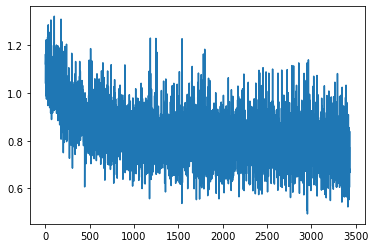

In [177]:
plt.plot(losses)

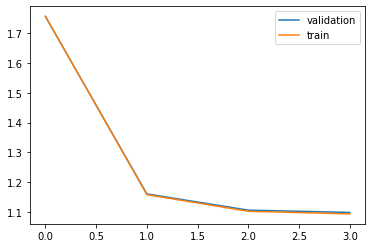

In [160]:
plt.plot(val_losses, label = "validation")
plt.plot(train_losses, label = "train")
plt.legend()

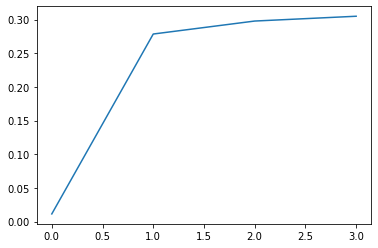

In [161]:
plt.plot(correlation)

In [162]:
movie_df

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama|Romance
4,4,Father of the Bride Part II (1995),Comedy
...,...,...,...
7018,7011,"Slipping-Down Life, A (1999)",Drama|Romance
7019,7012,Splatter University (1984),Horror
7020,7013,Twist (2003),Drama
7021,7014,Control Room (2004),Documentary|War


In [163]:

movie_df["title"]

0                                        Toy Story (1995)
1                                          Jumanji (1995)
2                                 Grumpier Old Men (1995)
3                                Waiting to Exhale (1995)
4                      Father of the Bride Part II (1995)
                              ...                        
7018                         Slipping-Down Life, A (1999)
7019                           Splatter University (1984)
7020                                         Twist (2003)
7021                                  Control Room (2004)
7022    Celsius 41.11: The Temperature at Which the Br...
Name: title, Length: 7023, dtype: object

In [164]:

movie_df["title"].nunique()

7023

In [165]:
rating_df["movieId"].nunique()

7023

In [166]:
movie_df['title'].to_dict()

{0: 'Toy Story (1995)',
 1: 'Jumanji (1995)',
 2: 'Grumpier Old Men (1995)',
 3: 'Waiting to Exhale (1995)',
 4: 'Father of the Bride Part II (1995)',
 5: 'Heat (1995)',
 6: 'Sabrina (1995)',
 7: 'Tom and Huck (1995)',
 8: 'Sudden Death (1995)',
 9: 'GoldenEye (1995)',
 10: 'American President, The (1995)',
 11: 'Dracula: Dead and Loving It (1995)',
 12: 'Balto (1995)',
 13: 'Nixon (1995)',
 14: 'Cutthroat Island (1995)',
 15: 'Casino (1995)',
 16: 'Sense and Sensibility (1995)',
 17: 'Four Rooms (1995)',
 18: 'Ace Ventura: When Nature Calls (1995)',
 19: 'Money Train (1995)',
 20: 'Get Shorty (1995)',
 21: 'Copycat (1995)',
 22: 'Assassins (1995)',
 23: 'Powder (1995)',
 24: 'Leaving Las Vegas (1995)',
 25: 'Othello (1995)',
 26: 'Now and Then (1995)',
 27: 'Persuasion (1995)',
 28: 'City of Lost Children, The (Cité des enfants perdus, La) (1995)',
 29: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 30: 'Dangerous Minds (1995)',
 31: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995

In [167]:
rating_df['movieId'].value_counts().to_frame('ratings').join(movie_df['title']).head(20)

,ratings,title
78,80494,Once Upon a Time... When We Were Colored (1995)
75,79990,"White Balloon, The (Badkonake sefid) (1995)"
0,78776,Toy Story (1995)
254,73227,Little Women (1994)
154,71871,Congo (1995)
72,67903,Nico Icon (1995)
82,63584,Dunston Checks In (1996)
85,59573,The Journey of August King (1995)
68,58707,"Misérables, Les (1995)"
290,58107,Pushing Hands (Tui shou) (1992)


In [175]:
movie_choice = movie_df["title"].to_dict()
title_ID_map = {title:id for id ,title in movie_choice.items()}
ID_title_map = {id:title for id ,title in movie_choice.items()}
movies_np = sess.run(movies_var)
movie_compare = movies_np[title_ID_map["Muppet Treasure Island (1996)"]]-movies_np
sim_movies = np.argsort(abs(movie_compare).sum(1))
sim_movies
movie_df.loc[sim_movies].head(20)

,movieId,title,genres
101,101,Muppet Treasure Island (1996),Adventure|Children|Comedy|Musical
3748,3746,Annie (1982),Children|Musical
4824,4820,Super Fuzz (a.k.a. Super Snooper) (Poliziotto ...,Action|Comedy|Sci-Fi
3359,3357,Held Up (1999),Comedy
1065,1065,Top Gun (1986),Action|Romance
6656,6649,Berlin: Symphony of a Great City (Berlin: Die ...,Documentary
417,417,Body Snatchers (1993),Horror|Sci-Fi|Thriller
5831,5824,Car Wash (1976),Comedy
3590,3587,"Suddenly, Last Summer (1959)",Drama
4085,4079,Cannonball Run II (1984),Action|Comedy


In [169]:
[(ID_title_map[id], count) for id, count in rating_df['movieId'].value_counts().iteritems()] 

[('Once Upon a Time... When We Were Colored (1995)', 80494),
 ('White Balloon, The (Badkonake sefid) (1995)', 79990),
 ('Toy Story (1995)', 78776),
 ('Little Women (1994)', 73227),
 ('Congo (1995)', 71871),
 ('Nico Icon (1995)', 67903),
 ('Dunston Checks In (1996)', 63584),
 ('The Journey of August King (1995)', 59573),
 ('Misérables, Les (1995)', 58707),
 ('Pushing Hands (Tui shou) (1992)', 58107),
 ('Beautiful Girls (1996)', 57072),
 ('Unforgettable (1996)', 56949),
 ('Fair Game (1995)', 56663),
 ('To Wong Foo, Thanks for Everything! Julie Newmar (1995)', 55219),
 ('Interview with the Vampire: The Vampire Chronicles (1994)', 54872),
 ('Muppet Treasure Island (1996)', 54445),
 ('Bridges of Madison County, The (1995)', 54191),
 ('Pulp Fiction (1994)', 53243),
 ('Hate (Haine, La) (1995)', 51785),
 ('Across the Sea of Time (1995)', 50651),
 ('Golden Earrings (1947)', 50410),
 ('Destiny Turns on the Radio (1995)', 50248),
 ('Braveheart (1995)', 49320),
 ('White Squall (1996)', 49159),
 ('

In [170]:

movie_compare = movies_np[title_ID_map["Goofy Movie, A (1995)"]]-movies_np
sim_movies = np.argsort(abs(movie_compare).sum(1))
sim_movies
movie_df.loc[sim_movies].head(20)

,movieId,title,genres
232,232,"Goofy Movie, A (1995)",Animation|Children|Comedy|Romance
2352,2352,Conquest of the Planet of the Apes (1972),Action|Sci-Fi
3059,3055,Buffy the Vampire Slayer (1992),Action|Comedy|Horror
208,208,Before the Rain (Pred dozhdot) (1994),Drama|War
5019,5015,Goin' South (1978),Comedy|Western
712,712,Heaven's Prisoners (1996),Crime|Thriller
1585,1585,Hurricane Streets (1997),Drama
2710,2706,Phantasm (1979),Horror|Sci-Fi
32,32,Wings of Courage (1995),Adventure|Romance|IMAX
106,106,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime


In [ ]:
movie_choice = movie_df["title"].to_dict()

In [ ]:
rating_df.shape